#  Overview

This notebook demonstrates how to discover raw RADARSAT-1 scenes from the EODMS Search service (STAC), evaluate their coverage over an area of interest, submit scenes to the EODMS Processing service (OGC Processes) for Level-1 processing, and download the resulting image products.


## Finding data using the EODMS Search API

In [1]:
%matplotlib inline

import os
import re
from pathlib import Path
import requests
import json
import boto3
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import contextily as ctx
from io import BytesIO

from datetime import datetime
from itertools import islice
from shapely.geometry import shape
from pystac_client import Client
from eodms_dds import dds

We will search for RADARDSAT-1 scenes over Montreal between May 1st and August 31st, 2007.

In [2]:
def get_bbox(geojson_path):
    """Extracts bounding box coordinates from an input vector data file"""
    gdf = gpd.read_file(geojson_path)
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(4326)
    bbox = tuple([float(b) for b in gdf.total_bounds])

    return bbox

In [3]:
# date range for search
start_date = '2007-05-01'
end_date = '2007-08-31'

# creating bounding box from input GeoJSON to use as spatial filter
geojson_path = 'montreal-limites-administratives.geojson'
aoi_gdf = gpd.read_file(geojson_path)
bbox = get_bbox(geojson_path)
bbox

(-73.9966021388108, 45.3854030130529, -73.4738652778201, 45.7075796336657)

In [4]:
# List all items in collection within date range that intersect with bounding box
catalog_url = 'https://www.eodms-sgdot.nrcan-rncan.gc.ca/search'
collection = 'Radarsat-1-Raw'

catalog = Client.open(catalog_url)

# Clear the cache - StacApiIO uses a different cache structure
if hasattr(catalog._stac_io, '_cached'):
    catalog._stac_io._cached.clear()
elif hasattr(catalog._stac_io, 'cache'):
    catalog._stac_io.cache.clear()

search = catalog.search(
    collections=[collection],
    bbox=bbox,
    datetime=f'{start_date}/{end_date}',
    limit=100,
    method='GET'
)

all_items = search.item_collection()
print(f'{len(all_items)} total products found')

# Filter for Single Beam Mode only (ScanSAR is currently unsupported for L1 processing)
items = [item for item in all_items if not item.properties.get('beam_mode').startswith('ScanSAR')]
print(f'{len(items)} Single Beam products after filtering')

33 total products found
22 Single Beam products after filtering


Sorting the list of Radarsat-1-Raw products by percent coverage of GeoJSON AOI:

In [5]:
def calculate_coverage(item, aoi_gdf):
    "''Calculate the percent coverage of a STAC item footprint over a provided AOI geometry"""

    # default UTM zones
    utm_crs = aoi_gdf.estimate_utm_crs().to_epsg()
    aoi_gdf_utm = aoi_gdf.to_crs(utm_crs)

    # create GDF from STAC geometry and calculate intersection
    item_geom = shape(item.to_dict()['geometry'])
    item_gdf = gpd.GeoDataFrame([{'geometry': item_geom}], crs='EPSG:4326').to_crs(utm_crs)
    intersection = gpd.overlay(item_gdf, aoi_gdf_utm, how='intersection')
    
    # get AOI area 
    aoi_area = aoi_gdf_utm.geometry.area.sum()
    
    if len(intersection) > 0:
        intersection_area = intersection.geometry.area.sum()
        coverage_percent = float(round((intersection_area / aoi_area) * 100, 1))
    else:
        coverage_percent = 0.0
    
    return coverage_percent

In [6]:
def create_coverage_table(items, aoi_gdf):
    """Sorts all STAC items from a Radarsat-1-RAW collection search by percent coverage of an AOI"""
    
    dict_list = []
    for item in items:
        # calcualte percent coverage
        aoi_coverage = calculate_coverage(item, aoi_gdf)

        # metadata from item properties
        item_dict = item.to_dict()
        dict_list.append({
            'id': item_dict.get('id'),
            'coverage': aoi_coverage,
            'datetime': item_dict.get('properties').get('datetime'),
            'orbit_direction': item_dict.get('properties').get('orbit_direction'),
            'relative_orbit': item_dict.get('properties').get('relative_orbit'),
            'beam_mnemonic': item_dict.get('properties').get('beam_mnemonic'),
            'polarizations': item_dict.get('properties').get('sar:polarizations')
        })

    # Return table with results
    coverage_table = pd.DataFrame(dict_list).sort_values(by='coverage', ascending=False)

    return coverage_table

In [7]:
coverage_table = create_coverage_table(items, aoi_gdf)
coverage_table[0:10]  # top 10 results by % coverage

,id,coverage,datetime,orbit_direction,relative_orbit,beam_mnemonic,polarizations
3,45f59331-c2a3-4f7c-8211-14883e548069,100.0,2007-05-06T22:47:29.754000Z,Ascending,20,F2,[HH]
2,c0b6e1be-60ff-4886-ae81-0b31bcf868b5,100.0,2007-05-06T22:47:26.961000Z,Ascending,20,F2,[HH]
4,8a8f02aa-4d9c-4d1d-99c5-5d9175456d6a,100.0,2007-05-06T22:47:30.268000Z,Ascending,20,F2,[HH]
9,3ae07aa6-6672-4aa0-b3c7-bb0ae5f64cbc,100.0,2007-05-30T22:47:23.115000Z,Ascending,20,F2,[HH]
20,a788d533-8b7e-44ae-a15e-806c96061964,100.0,2007-08-25T10:49:21.026000Z,Descending,227,S7,[HH]
10,3ace0f9a-e776-43ce-bc29-a94623a3f085,99.3,2007-05-30T22:47:26.750000Z,Ascending,20,F2,[HH]
21,5b8430ab-498d-496c-ad82-e636fc225dfb,97.8,2007-08-25T10:49:22.396000Z,Descending,227,S7,[HH]
8,3ace0f9a-e776-43ce-bc29-a94623a3f085,57.6,2007-05-30T22:47:19.375000Z,Ascending,20,F2,[HH]
7,3addb92e-17ea-4802-85d1-208c1379bbb3,37.2,2007-05-20T22:39:04.805000Z,Ascending,220,S2,[HH]
1,8a8f02aa-4d9c-4d1d-99c5-5d9175456d6a,33.8,2007-05-06T22:47:23.134000Z,Ascending,20,F2,[HH]


We will take the highest-coverage Standard Beam product (`beam_mnemonic='S*'`) for further processing, and visualize its footprint on the map below:

In [8]:
standard_beam_products = coverage_table[coverage_table['beam_mnemonic'].str.startswith('S')]
r1_product_id = standard_beam_products.iloc[0,0]
r1_item = [i for i in items if i.id == r1_product_id][0].to_dict()

In [9]:
def plot_item_footprint(item, aoi_gdf, figsize=(6, 6)):
    """Display a STAC item footprint over a basemap with a provided AOI geometry"""
    
    # Create geodataframe of item footprint
    if type(item) != dict:
        item = item.to_dict()

    item_geom = shape(item.get('geometry'))
    item_gdf = gpd.GeoDataFrame([{'geometry': item_geom}], crs=4326)

    # Reproject both GDFs to Web Mercator for basemap
    item_gdf_mercator = item_gdf.to_crs(3857)
    aoi_gdf_mercator = aoi_gdf.to_crs(3857)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot AOI
    aoi_gdf_mercator.boundary.plot(ax=ax, color='red', linewidth=2, label='AOI')
    aoi_gdf_mercator.plot(ax=ax, alpha=0.2, color='red', edgecolor='red')
    
    # Plot item footprint
    item_gdf_mercator.boundary.plot(ax=ax, color='blue', linewidth=2, label='Item Footprint')
    item_gdf_mercator.plot(ax=ax, alpha=0.1, color='blue', edgecolor='blue')
    
    # Add OSM basemap
    basemap=ctx.providers.OpenStreetMap.Mapnik
    ctx.add_basemap(ax, source=basemap, attribution_size=8)
    
    # Add title and legend
    item_id = item.get('id')
    datetime = item.get('properties').get('datetime', 'N/A')
    
    ax.set_title(f'Product ID: {item_id}\n\nAcquisition Date: {datetime}', 
                 fontsize=12, pad=10)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    
    plt.tight_layout()
    
    return fig, ax

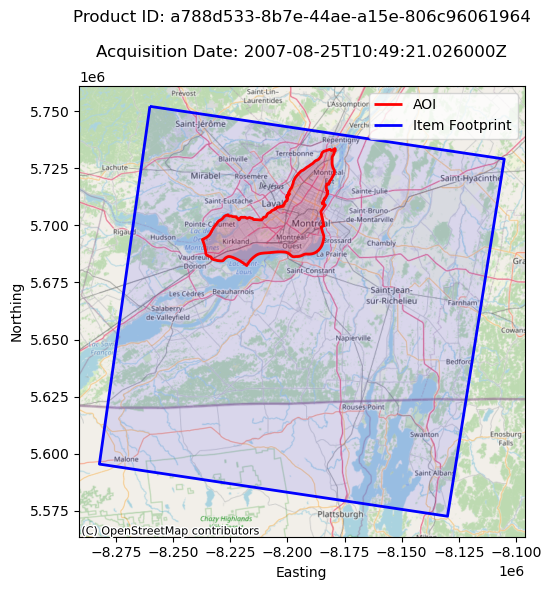

In [ ]:
fig, ax = plot_item_footprint(r1_item, aoi_gdf)
plt.show()

Additional properties of the raw Radarsat-1 frame item are as follows:

In [11]:
r1_item.get('properties')

{'segment_start_datetime': '2007-08-25T10:48:54.742+00:00',
 'datetime': '2007-08-25T10:49:21.026000Z',
 'beam_mode': 'Standard',
 'thumbnail': 'https://eodms-sgdot.nrcan-rncan.gc.ca/image/v1/browse/a788d533-8b7e-44ae-a15e-806c96061964',
 'dataset_id': 385657,
 'segment_id': '83865389-3adf-4265-83b8-c981a7f7e1a0',
 'beam_mnemonic': 'S7',
 'stop_datetime': '2007-08-25T10:49:37.903+00:00',
 'product_format': 'FRED',
 'relative_orbit': 227,
 'orbit_direction': 'Descending',
 'archive_facility': 'GATN',
 'acquisition_orbit': 61624,
 'reception_facility': 'GATN',
 'segment_stop_datetime': '2007-08-25T10:50:06.894+00:00',
 'sar:frequency_band': 'C',
 'sar:polarizations': ['HH'],
 'sar:beam_ids': ['S7'],
 'sar:center_frequency': '5.3',
 'proj:code': 'EPSG:4326'}

Visualizing the quicklook thumbnail from the STAC item metadata:

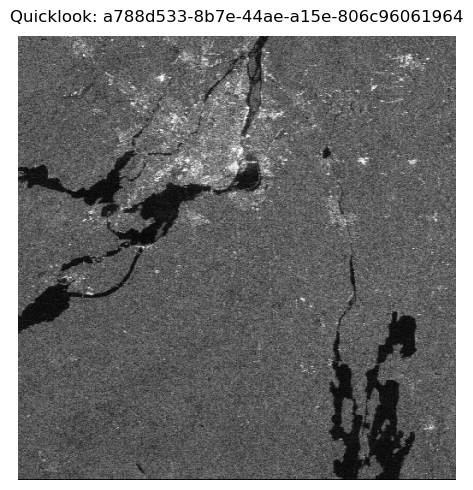

In [13]:
thumbnail_url = r1_item.get('properties').get('thumbnail')

try:
    response = requests.get(thumbnail_url)
    response.raise_for_status()
    
    # read JPEG image bytes with numpy
    img = mpimg.imread(BytesIO(response.content), format='jpg')
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Quicklook: {r1_product_id}", fontsize=12, pad=10)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Failed to fetch thumbnail: {e}")

## Submitting orders to the EODMS Processes API

All available processes can be listed through a GET request to the `/processing/processes` endpoint

In [14]:
api_url = 'https://eodms-sgdot.nrcan-rncan.gc.ca/processing'
r = requests.get(f'{api_url}/processes')

if r.status_code == 200:
    all_processes = json.loads(r.content)
else:
    raise Exception(f'Request failed with status {r.status_code}: {r.text}')

# summarize results
for process in all_processes.get('processes'):
    if 'title' in process.keys():
        print(json.dumps(dict(islice(process.items(), 4)), indent=4))

{
    "title": "Radarsat-1 CEOS-L0 RAW",
    "description": "Generate a Radarsat-1 CEOS L0 RAW product",
    "keywords": [
        "Radarsat-1",
        "RAW",
        "CEOS",
        "L0"
    ],
    "id": "Radarsat1CEOSL0RAW"
}
{
    "title": "Radarsat-1 GAMMA L1 SLC",
    "description": "Generate a Radarsat-1 L1 product in GAMMA SLC format",
    "keywords": [
        "Radarsat-1",
        "FRED",
        "SLC",
        "GAMMA",
        "L1"
    ],
    "id": "Radarsat1GAMMAL1SLC"
}
{
    "title": "Radarsat-1 CEOS L1 SLC (16-bit)",
    "description": "Generate Radarsat-1 L1 product in CEOS SLC (16-bit)",
    "keywords": [
        "Radarsat-1",
        "SLC",
        "CEOS L1"
    ],
    "id": "Radarsat1CEOSL1SLC"
}


We can find the required input structure for a given process using the `processing/processes/{processID}` endpoint:

In [15]:
process_id = 'Radarsat1GAMMAL1SLC'
r = requests.get(f'{api_url}/processes/{process_id}')

if r.status_code == 200:
    gamma_process_description = json.loads(r.content)
    print(json.dumps(gamma_process_description.get('inputs'), indent=4))
else:
    raise Exception(f'Request failed with status {r.status_code}: {r.text}')

{
    "lookup_table": {
        "maxOccurs": 1,
        "minOccurs": 0,
        "title": "lookup table",
        "enum": [
            "ice",
            "mixed",
            "point-target",
            "constant-beta"
        ],
        "description": "lookup table to use for processing (16-bit mode only)",
        "default": "mixed"
    },
    "stop_time": {
        "description": "Stop time of FRED dataset extraction",
        "minOccurs": 0,
        "maxOccurs": 1,
        "type": "string",
        "title": "stop time"
    },
    "slc_type": {
        "minOccurs": 0,
        "title": "slc type",
        "description": "SLC Type: sigma0, gamma0, beta0",
        "maxOccurs": 1,
        "default": "beta0",
        "enum": [
            "sigma0",
            "gamma0",
            "beta0"
        ]
    },
    "uuid": {
        "minOccurs": 1,
        "description": "The unique identifier of the L0 dataset",
        "type": "string",
        "maxOccurs": 1,
        "title": "uuid"
    },

An authorization token is required to send certain requests to the Processes API, created using your EODMS username and password. These values must be exported as environment variables `EODMS_USERNAME` and `EODMS_PASSWORD` before obtaining a token via the `AAA_API` class.

The following cell shows how to load these variables from a `.credentials` file with a structure of:

```bash
EODMS_USERNAME="foo"
EODMS_PASSWORD="bar"
```

In [16]:
credentials_path = '../.credentials'

if os.path.exists(credentials_path):
    with open(credentials_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                key, value = line.split('=', 1)
                value = value.strip('"').strip("'")
                os.environ[key] = value
    print('EODMS credentials loaded as environment variables from .credentials file')
else:
    print('No .credentials file found. Please set EODMS_USERNAME and EODMS_PASSWORD environment variables manually.')

EODMS credentials loaded as environment variables from .credentials file


In [17]:
aaa_api = dds.aaa.AAA_API(os.environ.get('EODMS_USERNAME'), os.environ.get('EODMS_PASSWORD'))
auth_token = aaa_api.get_access_token()

[ eodms_aaa ] Access Expiration: 2025-12-12 09:49:07.043634
[ eodms_aaa ] Refresh Expiration: 2025-12-12 10:38:07.043634
[ eodms_aaa ] Current Access Token has expired. Getting a new Access Token using current Refresh Token...
[ eodms_aaa ] Refresh Expiration: 2025-12-12 10:38:07.043634
[ eodms_aaa ] Current Access Token has expired. Getting a new Access Token using current Refresh Token...
[ eodms_aaa ] Successfully refreshed using AAA API
[ eodms_aaa ] Updating Access Token...
[ eodms_aaa ] Updating Refresh Token...
[ eodms_aaa ] Updating Access Expiration as 2025-12-12 09:57:11.695202...
[ eodms_aaa ] Updating Refresh Expiration as 2025-12-12 10:38:06.695202...
[ eodms_aaa ] Successfully refreshed using AAA API
[ eodms_aaa ] Updating Access Token...
[ eodms_aaa ] Updating Refresh Token...
[ eodms_aaa ] Updating Access Expiration as 2025-12-12 09:57:11.695202...
[ eodms_aaa ] Updating Refresh Expiration as 2025-12-12 10:38:06.695202...


The `Radarsat-1-Raw` collection represents individual R1 raw scenes/frames. The source raw data is stored in FRED (Framed Raw Expanded Data) format, where each entry represents a much larger segment/swath comprising of multiple frames.

To avoid processing unnecessary frames within a swath that don't overlap our study area, the Processes API accepts `start_time` and `stop_time` arguments that correspond to when individual frames were imaged. These values along with the FRED segment ID for each frame are stored in the STAC item metadata.

In [18]:
segment_id = r1_item.get('properties').get('segment_id')
img_start = r1_item.get('properties').get('datetime')
img_stop = r1_item.get('properties').get('stop_datetime')

Here is a function to submit a POST request to the `/processing/processes/{processID}/execution` endpoint given a FRED segment UUID and specific process ID with some other optional processing arguments:

In [19]:
def submit_r1_process(segment_id, 
                      process_id, 
                      auth_token, 
                      slc_type='beta0', 
                      lookup_table='mixed', 
                      start_time=None, 
                      stop_time=None):
    """
    process_id options: Radarsat1GAMMAL1SLC, Radarsat1CEOSL1SLC, Radarsat1CEOSL0RAW
    slc_type options: beta0 (default), sigma0, gamma0 
    lookup_table options (for 16-bit CEOS L1 only): mixed (default), ice, point-target, constant-beta
    """
    # build a JSON payload to POST to the endpoint
    payload = {
                'inputs': {
                    'uuid': segment_id,
                    'lookup_table': lookup_table,
                    'slc_type': slc_type,
                    'start_time': start_time,
                    'stop_time': stop_time
                },
                'outputs': {
                    f'{process_id}-response': {
                    'format': {
                        'mediaType': 'application/json'
                        }
                    }
                },
                'mode': 'async',
            }
    
    # drop any unused optional inputs
    if not start_time:
        payload.get('inputs').pop('start_time')
    if not stop_time:
        payload.get('inputs').pop('stop_time')

    # send POST request and return results
    headers = {
        'Authorization': f'Bearer {auth_token}',
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Prefer': 'respond-async'
    }
    
    api_url = 'https://eodms-sgdot.nrcan-rncan.gc.ca/processing'
    execution_url = f'{api_url}/processes/{process_id}/execution'
    # print(payload)
    print(json.dumps(payload, indent=4))


    r = requests.post(execution_url, headers=headers, json=payload)
    if r.status_code in [200, 201]:
        order_json = r.json()
        return order_json
    
    else:
        raise Exception(f'Request failed with status {r.status_code}: {r.text}')

In [20]:
segment_id = r1_item.get('properties').get('segment_id')
img_start = r1_item.get('properties').get('datetime')
img_stop = r1_item.get('properties').get('stop_datetime')

In [ ]:
r1_order = submit_r1_process(segment_id,
                             process_id,
                             auth_token=aaa_api.aaa_creds.access_token,
                             start_time=img_start,
                             stop_time=img_stop)

In [ ]:
print(json.dumps(r1_order, indent=4))
r1_order_id = r1_order.get('jobID')

## Monitoring job status

## Accessing resulting L1 products

The `/processing/jobs/{jobId}/results` endpoint contains information on job results, including URIs of the output L1 product files stored on AWS S3:

We can loop through each S3 URI in the results and download files locally with `boto3`